code from: /glade/work/mengyangz/GVP/oae-dor-global-efficiency/notebooks/CO2_uptake_histograms-South.py

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


%matplotlib inline

from glob import glob


import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import pop_tools



import util


import dask
from dask import delayed

import gsw

ModuleNotFoundError: No module named 'cmocean'

#  CO2 uptake histogram

### Calculate individual runs, tailored for Perlmutter runs

In [2]:
def cal_dist(target):    
    '''
    target: [lon, lat]
    '''

    n, m = tlong.shape

    dist = np.zeros_like(tlong)
    for i in range(n):
        for j in range(m):
            dist[i,j] = gsw.distance([tlong[i,j], target[0]], [tlat[i,j], target[1]])
    return dist

def make_rings(dist_0, num_rings=100):

    '''
    Return ring matrix, assign each grid point to a certain ring.
    bin_edges: distances
    '''
    
    # Determine the range of distances
    # min_distance = np.min(dist_0)
    # max_distance = np.max(dist_0)

    # Define the bin edges to create rings
    #bin_edges = np.concatenate((np.arange(0, 2000*1e3, 50*1e3), np.arange(2000*1e3, max_distance, 100*1e3)))
    bin_edges = np.arange(0, 4100*1e3, 50*1e3)

    # Use digitize to assign each point to a ring
    rings = np.digitize(dist_0, bin_edges, right=True)
    
    return bin_edges, rings

def get_cum_FG_CO2_ring(FG_CO2_excess, bin_edges_0, rings_0):
    
    '''
    Return array of cummulative percentage CO2 uptake in each rings
    '''
    
    # total CO2 uptake in each ring, and each time
    
    FG_CO2_excess_area_time = (FG_CO2_excess.FG_CO2_excess * FG_CO2_excess.TAREA * FG_CO2_excess.time_delta) / 1e6 * 86400 # mmol
    total_FG_CO2 = FG_CO2_excess_area_time.sum(dim=['time', 'nlat', 'nlon']).values

    num_time = len(FG_CO2_excess_area_time.time) # 180 time steps
    num_rings = len(bin_edges_0) # 82 bins
    
    FG_CO2_rings = np.zeros((num_time, num_rings))

    #print('rings_ind,', rings_ind)
    #print('num_rings,', num_rings)
    
    for i in range(num_rings):
        ring_mask = np.where(rings_0 == i+1, 1, 0)  # 1 if in this ring, ring index starts at 1
        FG_CO2_rings[:, i] = (FG_CO2_excess_area_time * ring_mask).sum(dim=['nlat', 'nlon']) # mmol

    #total_FG_CO2 = np.sum(FG_CO2_rings) # total CO2 uptake in 15 years, mmol
    FG_CO2_rings_per = FG_CO2_rings / total_FG_CO2
    
    return FG_CO2_rings_per

def get_cum_FG_CO2_ring_1case(region, polygon, season, bin_edges_0, rings_0):
    
    '''
    Return array of cummulative percentage CO2 uptake in each rings, 4 seasons
    
    region: North_Atlantic_basin
    '''
    
    FG_CO2_rings_per_1case = np.zeros((180, len(bin_edges_0)))
    
    #fpath = '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/key_model_vars/FG_CO2_excess/'
    fpath = '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/key_model_vars_Perlmutter/FG_CO2_excess/'
    
    FG_CO2_excess = xr.open_dataset(fpath + f'smyle.oae-map.{region}.{polygon:03d}.1999-{season}-01.001.nc')
    #smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001.nc
    
    #FG_CO2_excess = xr.open_dataset(fpath + f'{region}-{ind[i]:04d}.nc')
    FG_CO2_rings_per_1case[:, :] = get_cum_FG_CO2_ring(FG_CO2_excess, bin_edges_0, rings_0)
    
    return FG_CO2_rings_per_1case

def get_ds(FG_CO2_rings_0, bin_edges_0, reg, p, s):
    
    ds = xr.Dataset(
        {
            'FG_CO2_percent': (['time', 'dist2center'], FG_CO2_rings_0),
        },
        coords={
                'time': np.arange(0,180,1),
                'dist2center': bin_edges_0
               },
    )

    month_dic = {'01': 'January', '04': 'April', '07': 'July', '10': 'October'}
    ds = ds.expand_dims(polygon=[p])
    ds = ds.expand_dims(region=[reg])
    ds = ds.expand_dims(season=[month_dic[s]])
    
    return ds

Use dask

In [3]:
%%time
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)
tlong = grid.TLONG.values
tlat = grid.TLAT.values

tlong_conv = np.where(tlong > 180, tlong - 360, tlong)

# polygon centers
Pacific_cluster_centers = np.load('/glade/work/mengyangz/GVP/Pacific_final_cluster_centers.npy',allow_pickle=True)
Atlantic_cluster_centers = np.load('/glade/work/mengyangz/GVP/Atlantic_final_cluster_centers.npy',allow_pickle=True)
South_cluster_centers = np.load('/glade/work/mengyangz/GVP/South_final_cluster_centers_120EEZ_180openocean.npy',allow_pickle=True)
Southern_Ocean_cluster_centers = np.load('/glade/work/mengyangz/GVP/Southern_Ocean_final_cluster_centers.npy',allow_pickle=True)   

centers = [Atlantic_cluster_centers, Pacific_cluster_centers, South_cluster_centers, Southern_Ocean_cluster_centers]

def cal_FG_CO2_hist(case, run_id):

    if 'Pacific' in case:
        region = 'North_Pacific_basin'
        region_ind = 1
    elif 'Atlantic' in case:
        region = 'North_Atlantic_basin'
        region_ind = 0
    elif 'South' in case and 'Ocean' not in case:
        region = 'South'
        region_ind = 2
    elif 'Southern_Ocean' in case:
        region = 'Southern_Ocean'
        region_ind = 3

    month = case[-9:-7]
    poly = int(case[-18:-15])
    
    print(run_id, case, region, poly, month)

    cent = centers[region_ind]
    dist_ = cal_dist(cent[poly])
    bin_edges_, rings_ = make_rings(dist_)
    FG_CO2_rings_ = get_cum_FG_CO2_ring_1case(region, poly, month, bin_edges_, rings_)

    ds_ = get_ds(FG_CO2_rings_, bin_edges_, region, poly, month)
    ds_.to_netcdf(f'./Plumes_FG_CO2_histograms_Perlmutter/smyle.oae-map.{region}.{poly:03d}.1999-{month}-01.001.nc', mode='w')

CPU times: user 66.8 ms, sys: 2.71 ms, total: 69.5 ms
Wall time: 47 ms


In [5]:
# all cases on Perlmutter
p_perl = '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Perlmutter-Integrations/'
p_perl_files = sorted(glob(f'{p_perl}/smyle.oae-map.*.001'))
all_saved_cases = []
for i in p_perl_files:
    all_saved_cases.append(i.split('/')[-1])
len(all_saved_cases), all_saved_cases[:2]

(738,
 ['smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001',
  'smyle.oae-map.North_Atlantic_basin.000.1999-07-01.001'])

In [6]:
%%time
l_todo = list(range(len(all_saved_cases)))

with dask.config.set(scheduler='processes'):
   dask.compute([delayed(cal_FG_CO2_hist)(all_saved_cases[run_id], run_id) for run_id in l_todo])  # Parallel computation

479 smyle.oae-map.South.081.1999-10-01.001 South 81 10
528 smyle.oae-map.South.130.1999-10-01.001 South 130 10
118 smyle.oae-map.North_Atlantic_basin.071.1999-04-01.001 North_Atlantic_basin 71 04
249 smyle.oae-map.North_Pacific_basin.051.1999-10-01.001 North_Pacific_basin 51 10
276 smyle.oae-map.North_Pacific_basin.078.1999-10-01.001 North_Pacific_basin 78 10
652 smyle.oae-map.South.254.1999-10-01.001 South 254 10
433 smyle.oae-map.South.035.1999-10-01.001 South 35 10
345 smyle.oae-map.North_Pacific_basin.147.1999-10-01.001 North_Pacific_basin 147 10
127 smyle.oae-map.North_Atlantic_basin.082.1999-04-01.001 North_Atlantic_basin 82 04
335 smyle.oae-map.North_Pacific_basin.137.1999-10-01.001 North_Pacific_basin 137 10
231 smyle.oae-map.North_Pacific_basin.033.1999-10-01.001 North_Pacific_basin 33 10
99 smyle.oae-map.North_Atlantic_basin.052.1999-04-01.001 North_Atlantic_basin 52 04
75 smyle.oae-map.North_Atlantic_basin.035.1999-10-01.001 North_Atlantic_basin 35 10
395 smyle.oae-map.North

Check a few

In [4]:
res1 = xr.open_dataset('/glade/work/mengyangz/GVP/oae-dor-global-efficiency/notebooks/Plumes_FG_CO2_histograms/North_Atlantic_basin-0000.nc')
res2 = xr.open_dataset('/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Plumes_FG_CO2_histograms_Perlmutter/smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001.nc')

In [5]:
res1

<xarray.Dataset>
Dimensions:         (region: 1, polygon: 1, season: 4, time: 180, dist2center: 82)
Coordinates:
  * region          (region) object 'North_Atlantic_basin'
  * polygon         (polygon) int64 0
  * season          (season) object 'Januaray' 'April' 'July' 'October'
  * time            (time) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * dist2center     (dist2center) float64 0.0 5e+04 1e+05 ... 4e+06 4.05e+06
Data variables:
    FG_CO2_percent  (region, polygon, season, time, dist2center) float64 ...

(array([2.0000e+00, 5.0000e+00, 1.1000e+01, 1.4697e+04, 2.8000e+01,
        1.2000e+01, 3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-2.59460890e-05, -1.90224064e-05, -1.20987237e-05, -5.17504107e-06,
         1.74864159e-06,  8.67232424e-06,  1.55960069e-05,  2.25196896e-05,
         2.94433722e-05,  3.63670549e-05,  4.32907375e-05]),
 <BarContainer object of 10 artists>)

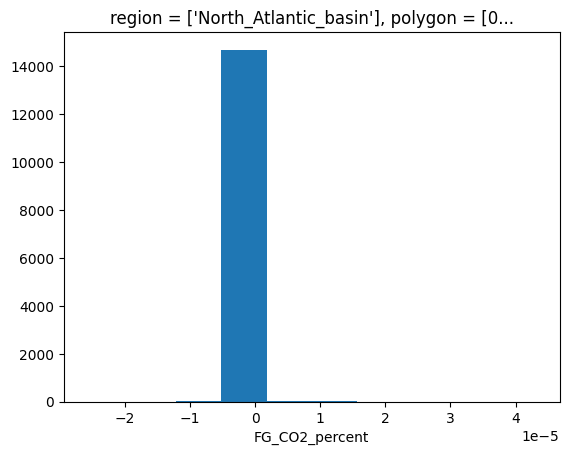

In [6]:
(res1['FG_CO2_percent'][0,:,3,:,:] - res2['FG_CO2_percent'][0,:,0,:,:]).plot.hist()

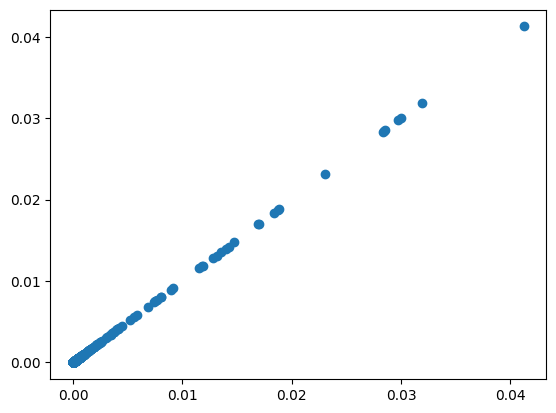

In [7]:
plt.scatter(res1['FG_CO2_percent'][0,:,3,:,:], res2['FG_CO2_percent'][0,:,0,:,:])

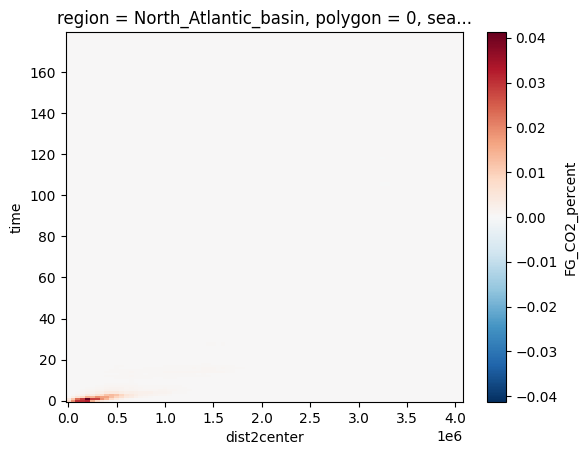

In [8]:
res1.isel(season=3, region=0, polygon=0).FG_CO2_percent.plot()

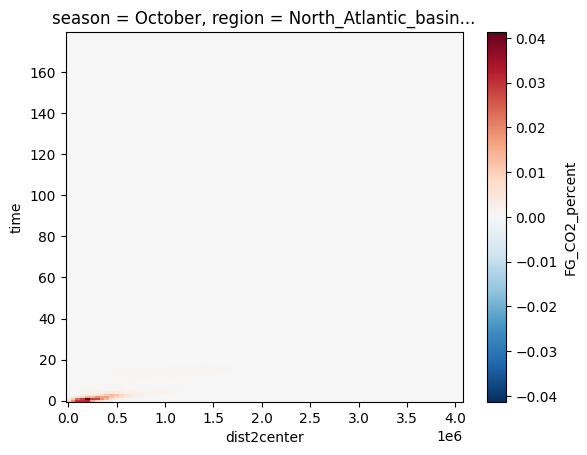

In [9]:
res2.isel(season=0, region=0, polygon=0).FG_CO2_percent.plot()

## Replace old results with new Perlmutter curves

In [10]:
# old all curves
old_combined_ds_all = xr.open_dataset('/glade/work/mengyangz/GVP/oae-dor-global-efficiency/notebooks/Plumes_FG_CO2_histograms/FG_CO2_histogram_all.nc')

# saved ones on Perlmutter
p_perl_saved = '/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Plumes_FG_CO2_histograms_Perlmutter/'
p_perl_files = sorted(glob(f'{p_perl_saved}/smyle.oae-map.*'))
# Get the case name:
all_cases_saved = []
for i in p_perl_files:
    all_cases_saved.append(i.split('/')[-1])
len(all_cases_saved), all_cases_saved[0]

(738, 'smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001.nc')

In [11]:
old_combined_ds_all

<xarray.Dataset>
Dimensions:         (polygon: 300, region: 4, season: 4, time: 180, dist2center: 82)
Coordinates:
  * polygon         (polygon) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * region          (region) object 'North_Atlantic_basin' ... 'Southern_Ocean'
  * season          (season) object 'Januaray' 'April' 'July' 'October'
  * time            (time) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * dist2center     (dist2center) float64 0.0 5e+04 1e+05 ... 4e+06 4.05e+06
Data variables:
    FG_CO2_percent  (region, polygon, season, time, dist2center) float64 ...

In [12]:
res2 = xr.open_dataset('/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Plumes_FG_CO2_histograms_Perlmutter/smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001.nc')

In [13]:
res2

<xarray.Dataset>
Dimensions:         (season: 1, region: 1, polygon: 1, time: 180, dist2center: 82)
Coordinates:
  * season          (season) object 'October'
  * region          (region) object 'North_Atlantic_basin'
  * polygon         (polygon) int64 0
  * time            (time) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * dist2center     (dist2center) float64 0.0 5e+04 1e+05 ... 4e+06 4.05e+06
Data variables:
    FG_CO2_percent  (season, region, polygon, time, dist2center) float64 ...

In [15]:
def replace_FG_CO2_curves():
    '''
    c: long case name: 'smyle.oae-map.Southern_Ocean.000.1999-10-01.001.nc'
    
    '''
    
    old_combined_ds_all = xr.open_dataset('/glade/work/mengyangz/GVP/oae-dor-global-efficiency/notebooks/Plumes_FG_CO2_histograms/FG_CO2_histogram_all.nc')
    old_combined_ds_all.load()
    
    region_dic = {'Atlantic': 0, 'Pacific': 1, 'South': 2, 'Southern_Ocean': 3}
    
    # saved ones on Perlmutter
    p_perl_saved = '/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Plumes_FG_CO2_histograms_Perlmutter/'
    p_perl_files = sorted(glob(f'{p_perl_saved}/smyle.oae-map.*'))
    # Get the case name:
    all_cases_saved = []
    for i in p_perl_files:
        all_cases_saved.append(i.split('/')[-1])

    for c in all_cases_saved:
        case = c[:-3]
        
        # find the region in the case name
        if 'Pacific' in case:
            region = 'Pacific'
        elif 'Atlantic' in case:
            region = 'Atlantic'
        elif 'South' in case and 'Ocean' not in case:
            region = 'South'
        elif 'Southern_Ocean' in case:
            region = 'Southern_Ocean'
        
        # find the polygon number in the case name
        poly = int(case[-18:-15])
        
        # find the month in the case name
        month = case[-9:-7]
    
        #print(region, poly, month)
        
        res = xr.open_dataset(f'{p_perl_saved}/{c}')
        
        if res['FG_CO2_percent'].notnull().any():  # variables saved
    
            ind_region = region_dic[region]
            ind_season = int(month)//3
            #print(ind_region, ind_season, poly)
            old_combined_ds_all['FG_CO2_percent'][ind_region, poly, ind_season, :, :] = res['FG_CO2_percent'][0,0,0,:,:]
    
            # after replacing with new curves
            #new_ = all_curves_old.isel(polygon=poly, season=int(month)//3, region=region_dic[region]).OAE_efficiency
    
            
    return old_combined_ds_all

In [16]:
%%time
new_combined_ds_all = replace_FG_CO2_curves()

CPU times: user 3.72 s, sys: 361 ms, total: 4.08 s
Wall time: 4.08 s


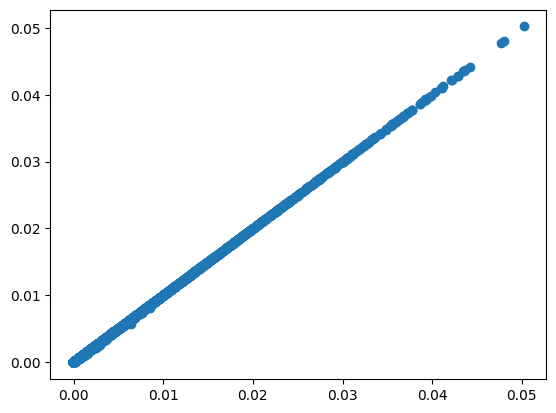

In [17]:
plt.scatter(old_combined_ds_all['FG_CO2_percent'][0,:,3,:,:], new_combined_ds_all['FG_CO2_percent'][0,:,3,:,:])

In [20]:
new_combined_ds_all.to_netcdf('/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Update_dataset_Perlmutter_Sept26_2024/curves_CO2spread.nc')

### Stitch them to maps

In [22]:
combined_ds_all = xr.open_dataset('/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Update_dataset_Perlmutter_Sept26_2024/curves_CO2spread.nc')

In [23]:
combined_ds_all

<xarray.Dataset>
Dimensions:         (polygon: 300, region: 4, season: 4, time: 180, dist2center: 82)
Coordinates:
  * polygon         (polygon) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * region          (region) object 'North_Atlantic_basin' ... 'Southern_Ocean'
  * season          (season) object 'Januaray' 'April' 'July' 'October'
  * time            (time) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * dist2center     (dist2center) float64 0.0 5e+04 1e+05 ... 4e+06 4.05e+06
Data variables:
    FG_CO2_percent  (region, polygon, season, time, dist2center) float64 ...

In [24]:
def find_element_index(arr, element_to_find):
    """
    Find the index (or indices) of a specified element in a NumPy array.

    Parameters:
    - arr: NumPy array
    - element_to_find: Element to search for in the array

    Returns:
    - If the element is found:
      - If the element appears multiple times, returns a NumPy array of indices.
      - If the element appears only once, returns a single index.
    - If the element is not found, returns None.
    """
    indices = np.where(arr == element_to_find)[0]

    if len(indices) == 0:
        return None
    elif len(indices) == 1:
        return indices[0]
    else:
        return indices
    
def get_stack(FG_CO2_rings_per, long=False):

    all_rs = [3,6,12,24,72,180]
    r=0
    stacks = []
    labels = []

    for rs in all_rs:
        # sum individual histograms across the time axis into groups.
        stacks.append(np.sum(FG_CO2_rings_per[r:rs],axis=0)*100)
        percentage = np.sum(FG_CO2_rings_per[r:rs])
        
        if long is True:
            labels.append("%.1f %% in months %d-%d"%(percentage*100,r,rs))
        else:
            labels.append("%.1f %%"%(percentage*100))
        # move to the next block
        r=rs
        
    return stacks, labels


def get_percent_dist(FG_CO2_percent, bin_edges_0, dist, time_window=180):
    '''
    Get the total perent of CO2 uptake, for a case
    dist: in km
    time steps to integrate: default 180 months, the whole 15 years
    '''
    
    
    #stacks, labels = get_stack(FG_CO2_percent)
    
    ind = find_element_index(bin_edges_0/1e3, dist)
    partial_total_labels = 100*np.sum(FG_CO2_percent[:time_window, 0:ind])

    return partial_total_labels

In [25]:
grid = pop_tools.get_grid('POP_gx1v7')[['TAREA', 'KMT', 'TLAT', 'TLONG', 'REGION_MASK']]
tlong = grid.TLONG.values
tlat = grid.TLAT.values

Pacific_polygon_masks = np.load('/glade/work/mengyangz/GVP/Pacific_final_polygon_mask.npy')
Pacific_polygon_vertices = np.load('/glade/work/mengyangz/GVP/Pacific_final_polygon_vertices.npy',allow_pickle=True)
Pacific_cluster_centers = np.load('/glade/work/mengyangz/GVP/Pacific_final_cluster_centers.npy',allow_pickle=True)

Atlantic_polygon_masks = np.load('/glade/work/mengyangz/GVP/Atlantic_final_polygon_mask.npy')
Atlantic_polygon_vertices = np.load('/glade/work/mengyangz/GVP/Atlantic_final_polygon_vertices.npy',allow_pickle=True)
Atlantic_cluster_centers = np.load('/glade/work/mengyangz/GVP/Atlantic_final_cluster_centers.npy',allow_pickle=True)

South_polygon_masks = np.load('/glade/work/mengyangz/GVP/South_final_polygon_mask_120EEZ_180openocean.npy')
South_polygon_vertices = np.load('/glade/work/mengyangz/GVP/South_final_polygon_vertices_120EEZ_180openocean.npy',allow_pickle=True)
South_cluster_centers = np.load('/glade/work/mengyangz/GVP/South_final_cluster_centers_120EEZ_180openocean.npy',allow_pickle=True)

Southern_Ocean_polygon_masks = np.load('/glade/work/mengyangz/GVP/Southern_Ocean_final_polygon_mask.npy')
Southern_Ocean_polygon_vertices = np.load('/glade/work/mengyangz/GVP/Southern_Ocean_final_polygon_vertices.npy',allow_pickle=True)
Southern_Ocean_cluster_centers = np.load('/glade/work/mengyangz/GVP/Southern_Ocean_final_cluster_centers.npy',allow_pickle=True)

In [26]:
regs = ['North_Atlantic_basin', 'North_Pacific_basin', 'South', 'Southern_Ocean']
num_polys = [150, 200, 300, 40]
all_region_masks = [Atlantic_polygon_masks, Pacific_polygon_masks, South_polygon_masks, Southern_Ocean_polygon_masks]

In [27]:
combined_ds_all = combined_ds_all.load()

In [28]:
combined_ds_all

<xarray.Dataset>
Dimensions:         (polygon: 300, region: 4, season: 4, time: 180, dist2center: 82)
Coordinates:
  * polygon         (polygon) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * region          (region) object 'North_Atlantic_basin' ... 'Southern_Ocean'
  * season          (season) object 'Januaray' 'April' 'July' 'October'
  * time            (time) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * dist2center     (dist2center) float64 0.0 5e+04 1e+05 ... 4e+06 4.05e+06
Data variables:
    FG_CO2_percent  (region, polygon, season, time, dist2center) float64 0.00...

In [30]:
def get_map_uptake_percent(dist, time_window=180):
    
    '''
    Generate maps pf the percent of CO2 uptake within a certain distance.
    '''

    x,y = tlong.shape
    whole_eff = np.zeros((4, x, y)) # store 4 seasons of map view

    bin_edges = combined_ds_all.dist2center.values

    for r, n, masks in zip(regs, num_polys, all_region_masks):

        for p in range(n):  # number of polygons
            mask = masks[p]

            for s in range(4):  # 4 seasons
                FG_CO2_temp = combined_ds_all.sel(region=r).isel(polygon=p, season=s).FG_CO2_percent.values
                value = get_percent_dist(FG_CO2_temp, bin_edges, dist, time_window = time_window)  

                eff = mask * value
                index = np.where(eff > 0)
                whole_eff[s,:,:][index] = eff[index]

    whole_eff = np.where(whole_eff == 0, np.nan, whole_eff)  
    
    # form a dataset
    whole_eff_ds = xr.Dataset(

        data_vars = {
            'uptake_percent': (["season", "nlat", "nlon"], whole_eff),
        },
        coords=dict(
            season = (["season"], combined_ds_all.season.values),
            TLONG=(["nlat", "nlon"], tlong),
            TLAT=(["nlat", "nlon"], tlat),
        ),
    )
    
    whole_eff_ds = whole_eff_ds.expand_dims(dist2center=[dist])
    whole_eff_ds = whole_eff_ds.expand_dims(time_window=[time_window])
    
    return whole_eff_ds

def get_all_dists(dists, time_window=180):
    
    '''all distances'''
    
    # 500 km
    print(f'--calculating time_window: {time_window}')
    whole_ds = get_map_uptake_percent(dists[0], time_window = time_window)
    
    for i in dists[1:]:
        print(f'dist {i}')
        whole_eff_ds_temp = get_map_uptake_percent(i, time_window = time_window)

        whole_ds = xr.concat((whole_ds, whole_eff_ds_temp), dim='dist2center')
    
    whole_ds.to_netcdf(f'/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Update_dataset_Perlmutter_Sept26_2024/Uptake_percent_maps-{time_window}months.nc')
    #return whole_ds


###### this takes a long time ro run
# def get_all_dists_times(time_windows):
    
#     '''all distances'''
    
#     dists = combined_ds_all.dist2center.values/1e3
    
#     whole_ds = get_all_dists(dists, time_window=time_windows[0])
       
#     for i in time_windows[1:]:
#         print(f'time_window {i}')
#         whole_eff_ds_temp = get_all_dists(dists, time_window=i)

#         whole_ds = xr.concat((whole_ds, whole_eff_ds_temp), dim='time_window')
    
#     return whole_ds

Calculate each time window

In [32]:
%%time
dists = combined_ds_all.dist2center.values/1e3

time_windows = [3, 6, 12, 12*2, 12*5, 12*10, 12*15]
for t in time_windows:
    get_all_dists(dists, time_window=t)

--calculating time_window: 3
dist 50.0
dist 100.0
dist 150.0
dist 200.0
dist 250.0
dist 300.0
dist 350.0
dist 400.0
dist 450.0
dist 500.0
dist 550.0
dist 600.0
dist 650.0
dist 700.0
dist 750.0
dist 800.0
dist 850.0
dist 900.0
dist 950.0
dist 1000.0
dist 1050.0
dist 1100.0
dist 1150.0
dist 1200.0
dist 1250.0
dist 1300.0
dist 1350.0
dist 1400.0
dist 1450.0
dist 1500.0
dist 1550.0
dist 1600.0
dist 1650.0
dist 1700.0
dist 1750.0
dist 1800.0
dist 1850.0
dist 1900.0
dist 1950.0
dist 2000.0
dist 2050.0
dist 2100.0
dist 2150.0
dist 2200.0
dist 2250.0
dist 2300.0
dist 2350.0
dist 2400.0
dist 2450.0
dist 2500.0
dist 2550.0
dist 2600.0
dist 2650.0
dist 2700.0
dist 2750.0
dist 2800.0
dist 2850.0
dist 2900.0
dist 2950.0
dist 3000.0
dist 3050.0
dist 3100.0
dist 3150.0
dist 3200.0
dist 3250.0
dist 3300.0
dist 3350.0
dist 3400.0
dist 3450.0
dist 3500.0
dist 3550.0
dist 3600.0
dist 3650.0
dist 3700.0
dist 3750.0
dist 3800.0
dist 3850.0
dist 3900.0
dist 3950.0
dist 4000.0
dist 4050.0
--calculating time_

Put all time windows together

In [33]:
fpath = '/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Update_dataset_Perlmutter_Sept26_2024/'

whole_ds = xr.open_dataset(f'{fpath}/Uptake_percent_maps-3months.nc')
for i in time_windows[1:]:
    whole_ds_temp = xr.open_dataset(f'{fpath}/Uptake_percent_maps-{i}months.nc')
    whole_ds = xr.concat((whole_ds, whole_ds_temp), dim='time_window')

In [34]:
whole_ds.to_netcdf(f'{fpath}/Uptake_percent_maps_all_perlmutter.nc')

## Read from here

In [35]:
fpath = '/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Update_dataset_Perlmutter_Sept26_2024/'

whole_ds = xr.open_dataset(f'{fpath}/Uptake_percent_maps_all_perlmutter.nc')

In [36]:
mean_over_season = whole_ds.mean(dim='season')
std_over_season = whole_ds.std(dim='season')

In [37]:
mean_over_season = util.pop_add_cyclic(mean_over_season)
std_over_season = util.pop_add_cyclic(std_over_season)

In [38]:
mean_over_season

<xarray.Dataset>
Dimensions:         (nlat: 384, nlon: 321, time_window: 7, dist2center: 82)
Coordinates:
  * time_window     (time_window) int64 3 6 12 24 60 120 180
  * dist2center     (dist2center) float64 0.0 50.0 100.0 ... 4e+03 4.05e+03
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT            (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31
    TLONG           (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.57 -39.86
    uptake_percent  (time_window, dist2center, nlat, nlon) float64 nan ... nan

In [39]:
mean_over_season_dist  = whole_ds.mean(dim='season').mean(dim='dist2center')
std_over_season_dist  = whole_ds.mean(dim='season').std(dim='dist2center')

mean_over_season_dist = util.pop_add_cyclic(mean_over_season_dist)
std_over_season_dist = util.pop_add_cyclic(std_over_season_dist)

In [40]:
mean_over_season_dist  = whole_ds.sel(dist2center=slice(200, 4000)).mean(dim='dist2center')
std_over_season_dist  = whole_ds.sel(dist2center=slice(200, 4000)).std(dim='dist2center')

mean_over_season_dist = util.pop_add_cyclic(mean_over_season_dist)
std_over_season_dist = util.pop_add_cyclic(std_over_season_dist)

Only seasonal mean

In [41]:
np.arange(0, 360, 60)

array([  0,  60, 120, 180, 240, 300])

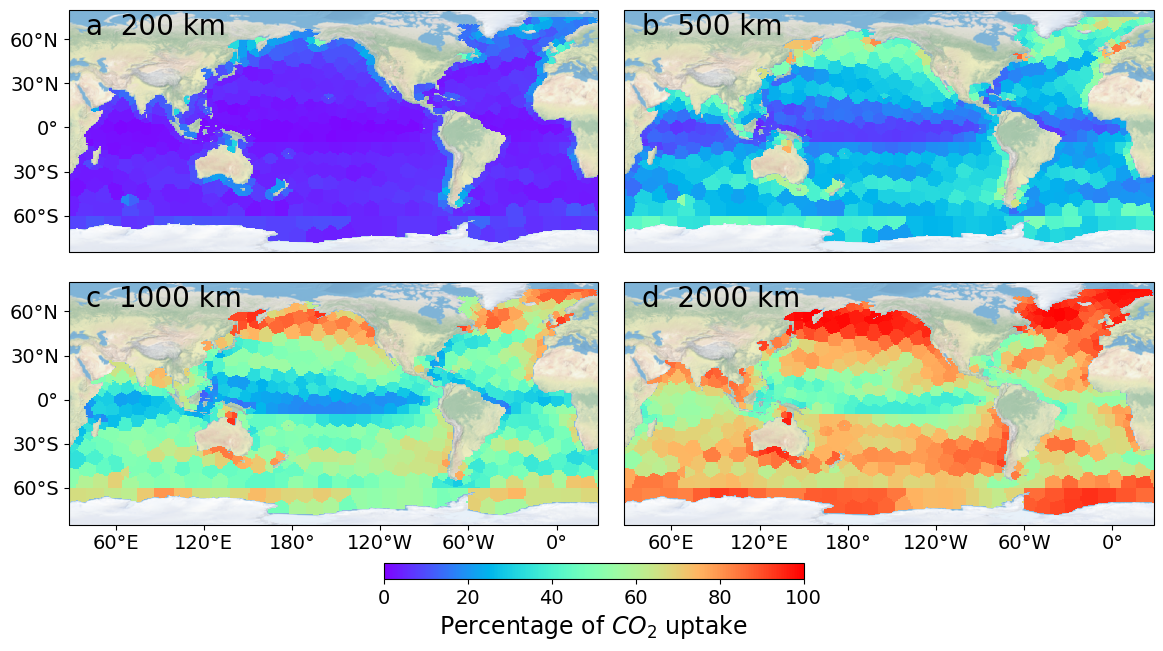

In [42]:
time_window = 180
dist2center = 1000

FONTSIZE = 14
def modify(ax):
    ax.set_extent([0, 360, -85, 80], crs=ccrs.PlateCarree())
    ax.stock_img()
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 
    # ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    # ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

central_longitude=208


dist2center = [200, 500, 1000, 2000]
labels = ['a  200 km', 'b  500 km', 'c  1000 km', 'd  2000 km']

fig = plt.figure(figsize=(14,7))

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection=ccrs.PlateCarree(central_longitude=central_longitude))
    ax.pcolormesh(mean_over_season.TLONG, mean_over_season.TLAT, mean_over_season.sel(time_window=time_window, dist2center=dist2center[i]).uptake_percent, transform=ccrs.PlateCarree(), cmap='rainbow', vmin=0, vmax=100)
    
    ax.text(40, 63, labels[i], fontsize=FONTSIZE+6, transform=ccrs.PlateCarree())
    
    if i in [0,2]:
        ax.set_yticks([-60,-30,0,30,60], crs=ccrs.PlateCarree())
        ax.set_yticklabels(ax.get_yticks(), fontsize=FONTSIZE)
    if i in [2,3]:
        ax.set_xticks(np.arange(0, 360, 60), crs=ccrs.PlateCarree())
        ax.set_xticklabels(ax.get_xticks(), fontsize=FONTSIZE)
        
    modify(ax)


def add_colorbar(x0, y0, vmin, vmax, label, num_levels_ticks, cmap_label='rainbow'):
    '''
    x0, y0: start location for the colorbar
    vmin, vmax: range of the colorbar
    label: label of the colorbar'
    '''
    cax = fig.add_axes([x0, y0, 0.3, 0.023])  # [x0, y0, width, height]
    cmap = plt.colormaps[cmap_label]
    normalize = plt.Normalize(vmin=vmin, vmax=vmax)  # Normalize the color values
    sm = cm.ScalarMappable(cmap=cmap, norm=normalize)
    cbar = fig.colorbar(sm, cax=cax, shrink=0.9, label=label, orientation='horizontal', ticks=np.linspace(vmin, vmax, num_levels_ticks))
    cbar.ax.tick_params(labelsize=FONTSIZE)
    cbar.ax.xaxis.label.set_size(FONTSIZE+3)

add_colorbar(0.35, 0.05, 0, 100, 'Percentage of $CO_2$ uptake', 6)
plt.subplots_adjust(wspace=0.05, hspace=0.02)
#plt.savefig(f'./figures/Uptake_percent_map-2x2-{int(time_window/12)}years.png', dpi=400, bbox_inches='tight')

### Validated the updated maps

In [56]:
fpath = '/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Update_dataset_Perlmutter_Sept26_2024/'
whole_ds = xr.open_dataset(f'{fpath}/Uptake_percent_maps_all_perlmutter.nc')

whole_ds_old = xr.open_dataset('/glade/work/mengyangz/GVP/Manuscript/Archive_code/Uptake_percent_maps_all.nc')

In [57]:
whole_ds

<xarray.Dataset>
Dimensions:         (time_window: 7, dist2center: 82, season: 4, nlat: 384, nlon: 320)
Coordinates:
  * time_window     (time_window) int64 3 6 12 24 60 120 180
  * dist2center     (dist2center) float64 0.0 50.0 100.0 ... 4e+03 4.05e+03
  * season          (season) object 'Januaray' 'April' 'July' 'October'
    TLONG           (nlat, nlon) float64 ...
    TLAT            (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    uptake_percent  (time_window, dist2center, season, nlat, nlon) float64 ...

Text(0.5, 1.0, 'Update percent: point to point comparison')

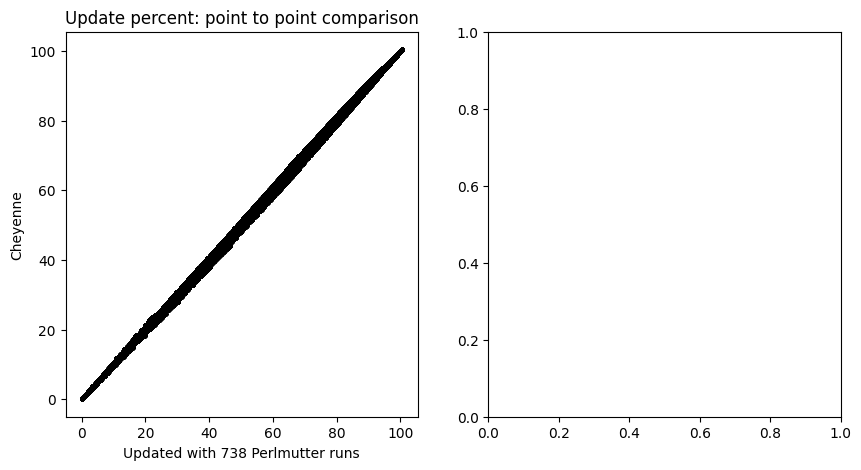

In [48]:
# Create two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(whole_ds.uptake_percent, whole_ds_old.uptake_percent, s=2, color='k')

# ax1.plot([-0.1,1], [-0.1,1], 'red',label='1:1', alpha=0.8)
# ax1.set_xlim(-0.1,1)
# ax1.set_ylim(-0.1,1)
ax1.set_xlabel('Updated with 738 Perlmutter runs')
ax1.set_ylabel('Cheyenne')
ax1.set_title('Update percent: point to point comparison')

# ax2.plot([-0.1,1], [-0.1,1], 'red',label='1:1', alpha=0.8)
# ax2.set_xlim(-0.1,0.6)
# ax2.set_ylim(-0.1,0.6)
# ax2.set_xlabel('Updated with 738 Perlmutter runs')
# ax2.set_ylabel('Cheyenne')
# ax2.set_title('Surface dilution: point to point comparison')

# ax1.legend()
# ax2.legend()

### Validate all curves for the interactive tools

In [6]:
fpath = '/glade/work/mengyangz/GVP/rerun_cesm/oae-dor-global-efficiency/notebooks/Update_dataset_Perlmutter_Sept26_2024/'
whole_ds = xr.open_dataset(f'{fpath}/curves_CO2spread.nc')

whole_ds_old = xr.open_dataset('/glade/work/mengyangz/GVP/oae-dor-global-efficiency/notebooks/Plumes_FG_CO2_histograms/FG_CO2_histogram_all.nc')

Text(0.5, 1.0, 'Update percent: point to point comparison')

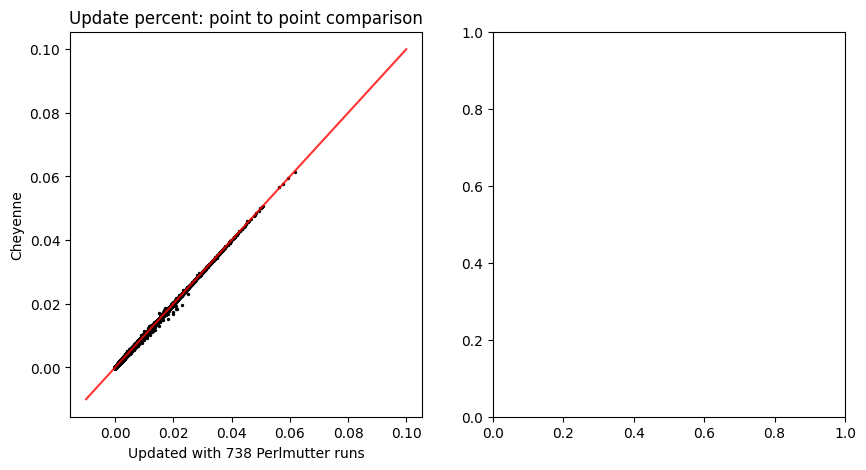

In [54]:
# Create two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(whole_ds.FG_CO2_percent, whole_ds_old.FG_CO2_percent, s=2, color='k')

ax1.plot([-0.01,0.1], [-0.01,0.1], 'red',label='1:1', alpha=0.8)
# ax1.set_xlim(-0.1,1)
# ax1.set_ylim(-0.1,1)
ax1.set_xlabel('Updated with 738 Perlmutter runs')
ax1.set_ylabel('Cheyenne')
ax1.set_title('Update percent: point to point comparison')

# ax2.plot([-0.1,1], [-0.1,1], 'red',label='1:1', alpha=0.8)
# ax2.set_xlim(-0.1,0.6)
# ax2.set_ylim(-0.1,0.6)
# ax2.set_xlabel('Updated with 738 Perlmutter runs')
# ax2.set_ylabel('Cheyenne')
# ax2.set_title('Surface dilution: point to point comparison')

# ax1.legend()
# ax2.legend()

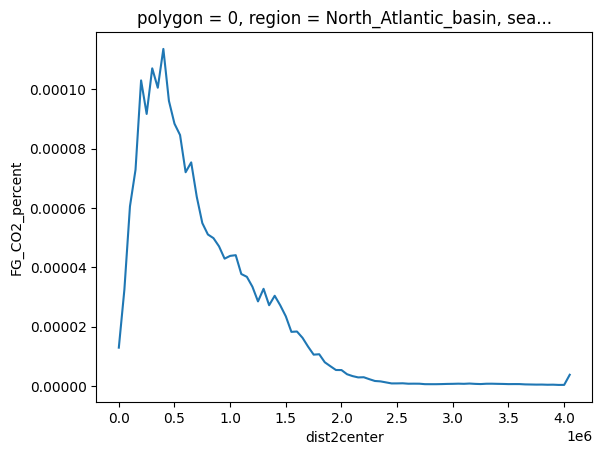

In [9]:
whole_ds.FG_CO2_percent[0,0,0,100].plot()